
### LLC4320 : Comparison Eulerian and Lagrangian basics statistics (mean velocity fields and variance)

Notation : 

Operators:

1) $\overline{.}$ : temporal mean (Eulerian framework)

2) $<.>_b$ : binned average, space only

3) $<.>_{b,t}$ : binned average, time and space

Velocity fields : 

1) Lagrangian raw velocity : u_L

2) Eulerian raw velocity : u_E

3) Eulerian temporal mean interpolated over the drifters trajectory : $\bar u_{E,i}$



\begin{align*}
\langle  \bar u_E  \rangle_b &= \langle  u  \rangle_{b,t} \\
\langle  \bar u_{E,i}  \rangle_{b, t} &= \langle  \rho \bar u_E  \rangle_{b,t} \\
&= \langle  \bar u_E  \rangle_b +  \langle  \rho (\bar u_E- \langle  \bar u_E  \rangle_b )  \rangle_{b,t} \\
\langle  u_{L}  \rangle_{b, t} &= \langle  \rho u  \rangle_{b,t} \\
&= \langle  \rho \bar u_E  \rangle_{b,t} +  \langle  \rho (u- \bar u_E)  \rangle_{b,t} \\
&= \langle \bar u_{E,i}  \rangle_{b,t} +  \langle  \rho (u- \bar u_E)  \rangle_{b,t} \\
\langle  \rho \rangle_{b,t} &= 1,
\end{align*}

In [2]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5587167.datarmor0/parcels-502090/libparcels_random_264deccc-1ad4-4805-b98c-8def0203650e.so


In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4)
#
client = Client(cluster)



In [5]:
client

<Client: 'tcp://10.148.1.67:56913' processes=14 threads=14, memory=223.58 GiB>

### Load data

In [6]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 



In [7]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lstats = ds_Lstats.compute()

In [8]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Eulerian diagnostics

In [9]:
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean","variance","mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds = xr.merge([ds,grid])
sub = 2
ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub),i_g=slice(0,None,sub),j_g=slice(0,None,sub))
#ds = ds.where(ds.Depth>500, drop=False)
ds = ds.persist()
print(ds)

<xarray.Dataset>
Dimensions:          (face: 13, i: 2160, i_g: 2160, j: 2160, j_g: 2160)
Coordinates: (12/20)
  * face             (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g              (i_g) int64 0 2 4 6 8 10 ... 4308 4310 4312 4314 4316 4318
  * j                (j) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * i                (i) int64 0 2 4 6 8 10 12 ... 4308 4310 4312 4314 4316 4318
  * j_g              (j_g) int64 0 2 4 6 8 10 ... 4308 4310 4312 4314 4316 4318
    CS               (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    ...               ...
    dyC              (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    dyG              (face, j, i_g) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rA               (face, j, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>
    rAs              (face, j_g, i) float32 dask.array<chunksize=(1, 2160, 2160), meta=

In [10]:
ds = ds.drop(['i_g','j_g'])

ds = ds.rename({'i_g':'i','j_g':'j'})

ds = ds.compute()

In [11]:
ds['lon'] = 0*ds.face+ds.XC
ds['lat'] = 0*ds.face+ds.YC

In [12]:
ds['zonal_velocity_mean'] =  ds['mean'+'_SSU']*ds.CS - ds["mean"+'_SSV']*ds.SN
ds['meridional_velocity_mean'] =  ds['mean'+'_SSU']*ds.SN + ds["mean"+'_SSV']*ds.CS

In [13]:
ds['zonal_velocity_var'] =  np.abs(ds['variance'+'_SSU']*ds.CS - ds["variance"+'_SSV']*ds.SN)
ds['meridional_velocity_var'] =  np.abs(ds['variance'+'_SSU']*ds.SN + ds["variance"+'_SSV']*ds.CS)

In [14]:
ds['zonal_velocity_mean_sq'] =  ds['mean_square'+'_SSU']*ds.CS - ds["mean_square"+'_SSV']*ds.SN
ds['meridional_velocity_mean_sq'] =  ds['mean_square'+'_SSU']*ds.SN + ds["mean_square"+'_SSV']*ds.CS

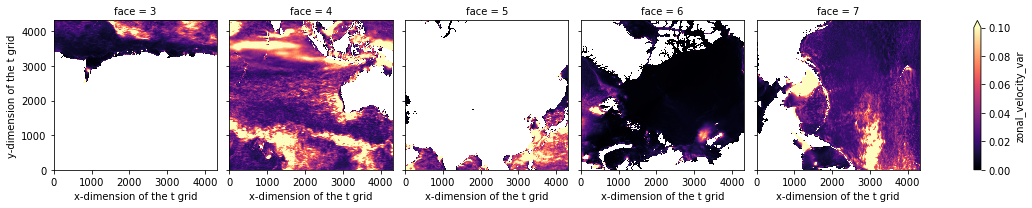

In [16]:
ds.zonal_velocity_var.isel(face=slice(3,8
                                          )).plot(col='face',vmax=0.1,vmin=0,cmap='magma')

#### Create xarray dataset with all faces assembled

In [15]:
ds_rot = llcreader.faces_dataset_to_latlon(ds.drop(['mean_SSU','mean_SSV','variance_SSU',
                                                    'variance_SSV','mean_square_SSU','mean_square_SSV']))

In [16]:
ds_rot = ds_rot.compute()
print(ds_rot)

<xarray.Dataset>
Dimensions:                      (face: 13, i: 8640, j: 6480)
Coordinates: (12/18)
  * face                         (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                            (j) int64 0 1 2 3 4 ... 6476 6477 6478 6479
  * i                            (i) int64 0 1 2 3 4 ... 8636 8637 8638 8639
    CS                           (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Depth                        (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SN                           (j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                           ...
    rAw                          (j, i) float32 1.555e+05 ... 1.141e+04
    rAz                          (j, i) float32 7.774e+04 ... 1.384e+04
    dxC                          (j, i) float32 324.6 324.6 ... 156.9 124.2
    dyC                          (j, i) float32 239.5 239.5 ... 134.9 112.4
    dyG                          (j, i) float32 479.0 479.0 ... 136.3 108.2
    dxG              

In [17]:
ds_rot = ds_rot.drop([C for C in ds_rot.zonal_velocity_mean.coords][2:])
ds_rot = ds_rot.drop(['face'])


df_rot = ds_rot.to_dataframe()    

### Useful functions

In [18]:
def binned_mean(df,dl):
    """Average dataframe over bins width dl
    
    Parameters 
    df : dataframe with at least longitude, latitude and field to bin in columns
    dl : bin width
    
    Returns
    df_mean : dataset with averaged fields
    """
    lon = np.arange(-180.,180., dl)
    lat = np.arange(-70., 70., dl)
    df['lon_cut'] = pd.cut(df['lon'], lon)
    df['lat_cut'] = pd.cut(df['lat'], lat)
    df_mean = df.groupby(['lon_cut','lat_cut']).mean()
    df_mean = pa.add_geodata(df_mean)
    df_mean = (df_mean
     #     .drop(columns=['Coordinates'])
          .set_index(['lon', 'lat'])
         .to_xarray()
        )
    return df_mean

In [19]:
def plot_maps(ds,vlim,colmap='RdBu_r',figsize = (10,5)):
    crs = ccrs.Robinson()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y='lat',ax=ax,transform=ccrs.PlateCarree(),cmap=colmap,label=False)
    ax.gridlines(draw_labels=True)
    return fig,ax

In [20]:
def plot_comparison(vmax,V,colmap='RdBu_r',figsize = (10,5)):

    columns= [ds_Estats[V+'_mean'],ds_Lstats['mean_'+V],ds_Lstats[V]]
    titles = [r'Eulerian mean '+V.split('_')[0]+r' velocity : $<\bar u_{E}>_{b}$',
            r'Eulerian mean '+V.split('_')[0]+r' velocity (interpolated over drifters trajectories) : $<\bar u_{E,i}>_{b,t}$',
            r'Lagrangian mean '+V.split('_')[0]+r' velocity : $<u_{L}>_{b,t}$']
    for col,title in zip(columns,titles):
        fig,ax = plot_maps(col,vmax,colmap=colmap)
        ax.set_title(title)

In [21]:
dl = 1.
ds_Estats = binned_mean(df_rot,dl)

ds_Estats

<xarray.Dataset>
Dimensions:                      (lat: 139, lon: 359)
Coordinates:
  * lon                          (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                          (lat) float64 -69.5 -68.5 -67.5 ... 67.5 68.5
Data variables:
    zonal_velocity_mean          (lon, lat) float32 -0.02983 0.01438 ... nan nan
    meridional_velocity_mean     (lon, lat) float32 0.02891 0.04721 ... nan nan
    zonal_velocity_var           (lon, lat) float32 0.005069 0.00766 ... nan nan
    meridional_velocity_var      (lon, lat) float32 0.004426 0.00674 ... nan nan
    zonal_velocity_mean_sq       (lon, lat) float32 0.006876 0.00827 ... nan nan
    meridional_velocity_mean_sq  (lon, lat) float32 -0.005345 -0.0092 ... nan

### Plot comparison Eulerian and Lagrangian global statistics

#### Mean flow : 
$<u_L>_{b,t}$ : binned Lagrangian raw velocity

$<\bar u_{E,i}>_{b,t}$ : binned Eulerian (temporal) mean field interpolaed over drifters trajectories

$<\bar u_E>_b$ : binned Eulerian (temporal) mean field

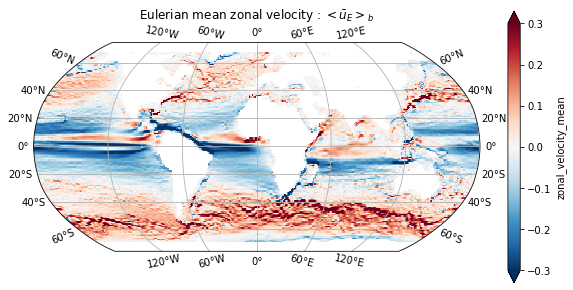

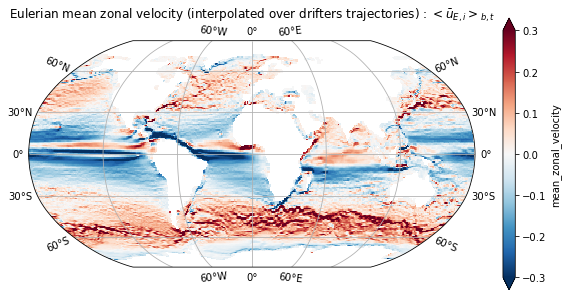

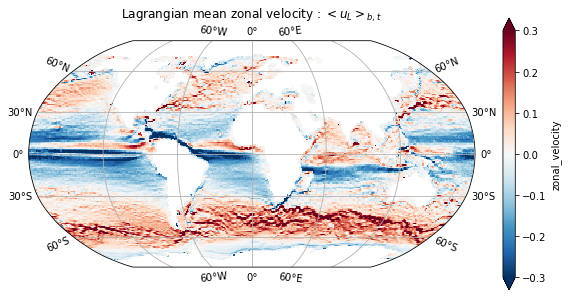

In [22]:
V = 'zonal_velocity'
plot_comparison([-0.3,0.3],V,colmap='RdBu_r',figsize = (10,5));

Text(0.5, 1.0, '$1-\\vert \\frac{<v_{L}>_{b,t}}{<\\bar v_{E}>_{b}}\\vert$')

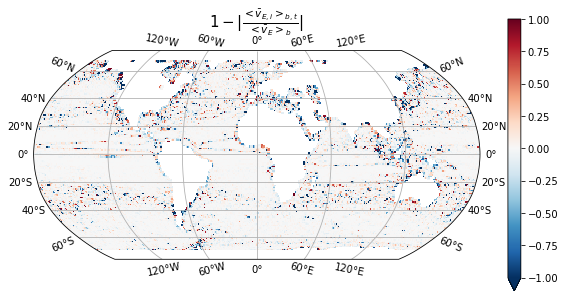

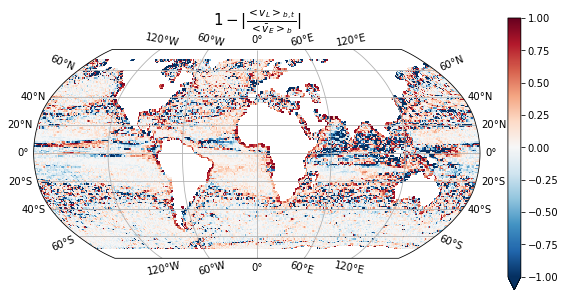

In [23]:
fig,ax = plot_maps((1-np.abs(ds_Lstats['mean_zonal_velocity']/ds_Estats['zonal_velocity_mean'])),[-1,1])
ax.set_title(r'$1-\vert \frac{<\bar v_{E,i}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)
fig,ax = plot_maps((1-np.abs(ds_Lstats['zonal_velocity']/ds_Estats['zonal_velocity_mean'])),[-1,1])
ax.set_title(r'$1-\vert \frac{<v_{L}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)

### Notes : 
Normalized difference to Eulerian mean field

Text(0.5, 1.0, '$\\vert <\\bar u_{E}>_{b}- <u_{L}>_{b,t}\\vert$')

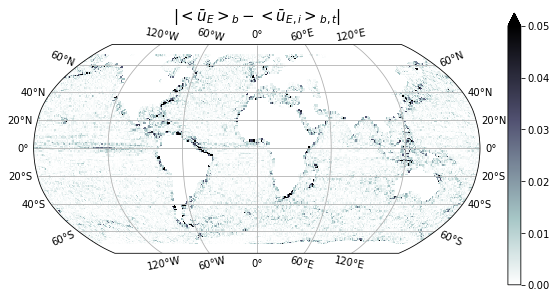

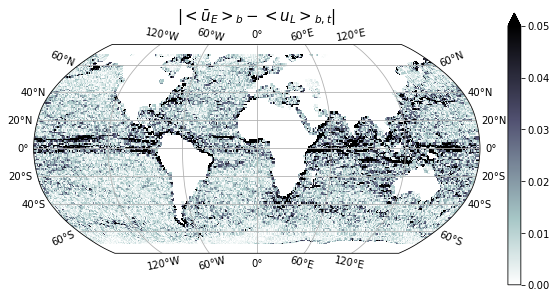

In [24]:
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_mean']-ds_Lstats['mean_zonal_velocity']),[0,0.05],colmap='bone_r')
ax.set_title(r'$\vert <\bar u_{E}>_{b}- <\bar u_{E,i}>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_mean']-ds_Lstats['zonal_velocity']),[0,0.05],colmap='bone_r')
ax.set_title(r'$\vert <\bar u_{E}>_{b}- <u_{L}>_{b,t}\vert$',fontsize=15)

#### Notes : Absolute difference of binned velocity field

1) Eulerian mean zonal velocity minus Eulerian mean zonal velocity interpolated over trajectories

2) Eulerian mean zonal velocity minus Lagrangian zonal velocity

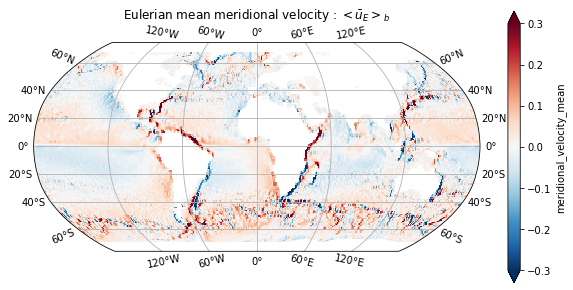

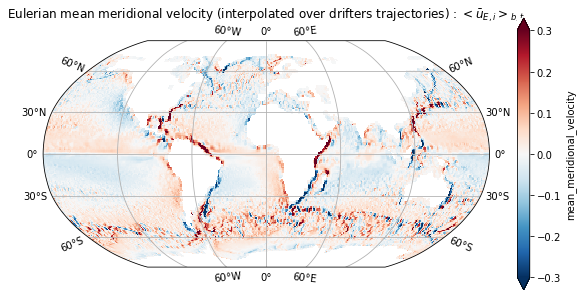

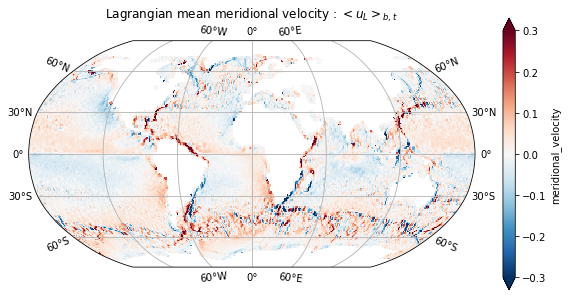

In [25]:
V = 'meridional_velocity'
plot_comparison([-0.3,0.3],V,colmap='RdBu_r',figsize = (10,5));

Text(0.5, 1.0, '$1-\\vert \\frac{<v_{L}>_{b,t}}{<\\bar v_{E}>_{b}}\\vert$')

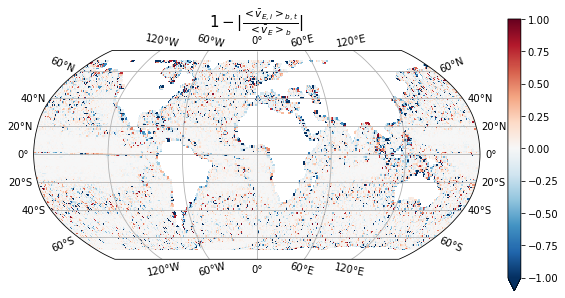

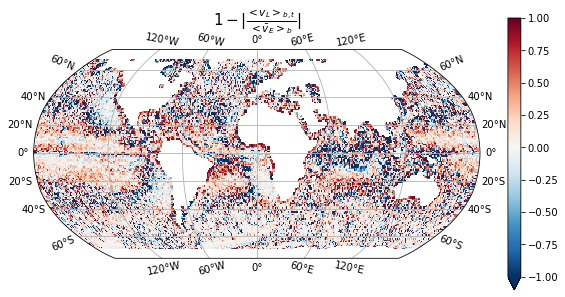

In [26]:
fig,ax = plot_maps((1-np.abs(ds_Lstats['mean_meridional_velocity']/ds_Estats['meridional_velocity_mean'])),[-1,1])
ax.set_title(r'$1-\vert \frac{<\bar v_{E,i}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)
fig,ax = plot_maps((1-np.abs(ds_Lstats['meridional_velocity']/ds_Estats['meridional_velocity_mean'])),[-1,1])
ax.set_title(r'$1-\vert \frac{<v_{L}>_{b,t}}{<\bar v_{E}>_{b}}\vert$',fontsize=15)

Text(0.5, 1.0, '$\\vert <\\bar v_{E}>_{b}- <v_{L}>_{b,t}\\vert$')

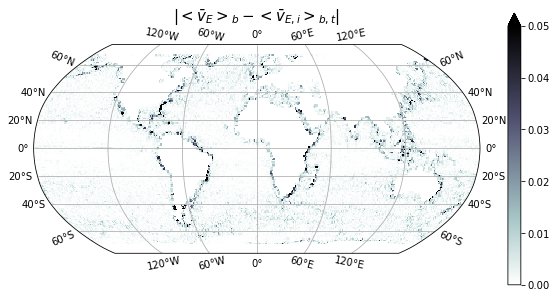

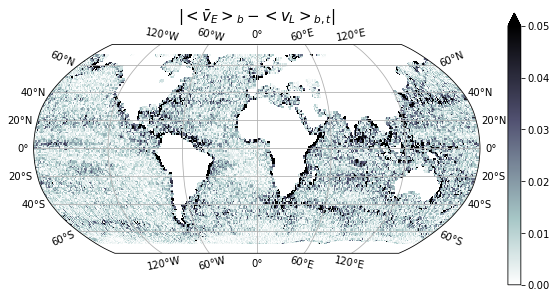

In [27]:
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_mean']-ds_Lstats['mean_meridional_velocity']),[0,0.05],colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <\bar v_{E,i}>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_mean']-ds_Lstats['meridional_velocity']),[0,0.05],colmap='bone_r')
ax.set_title(r'$\vert <\bar v_{E}>_{b}- <v_{L}>_{b,t}\vert$',fontsize=15)

In [22]:
ds_Estats['MKE'] = ds_Estats['zonal_velocity_mean']**2+ds_Estats['meridional_velocity_mean']**2
ds_Lstats['MKE_i'] = ds_Lstats['mean_zonal_velocity']**2+ds_Lstats['mean_meridional_velocity']**2
ds_Lstats['MKE_b'] = ds_Lstats['zonal_velocity']**2+ds_Lstats['meridional_velocity']**2

#### Notes : 
For simplification sake we will use the following notations :

1) MKE_E = $<\bar u_{E}>_{b}^2+<\bar v_{E}>_{b}^2$

2) MKE_i = $<\bar u_{E,i}>_{b,t}^2+<\bar v_{E,i}>_{b,t}^2$

3) MKE_b =  $<u_{L}>_{b,t}^2+<v_{L}>_{b,t}^2$

Text(0.5, 1.0, 'Lagrangian mean kinetic energy : $MKE_b$')

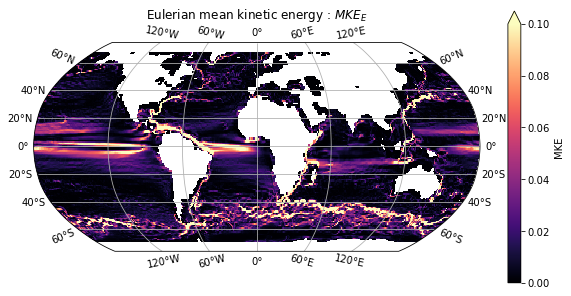

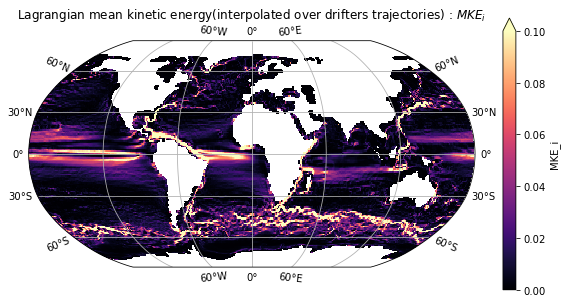

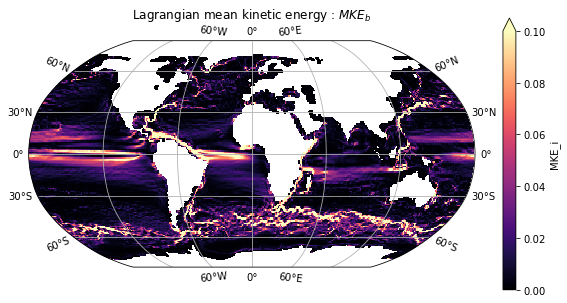

In [29]:
fig,ax = plot_maps(ds_Estats['MKE'],[0,0.1],colmap='magma')
ax.set_title(r'Eulerian mean kinetic energy : $MKE_E$')
fig,ax = plot_maps(ds_Lstats['MKE_i'],[0,0.1],colmap='magma')
ax.set_title(r'Lagrangian mean kinetic energy(interpolated over drifters trajectories) : $MKE_i$')
fig,ax = plot_maps(ds_Lstats['MKE_i'],[0,0.1],colmap='magma')
ax.set_title(r'Lagrangian mean kinetic energy : $MKE_b$')

Text(0.5, 1.0, '$\\vert MKE_E-MKE_b\\vert$')

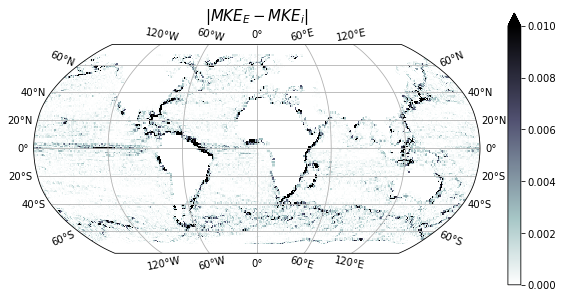

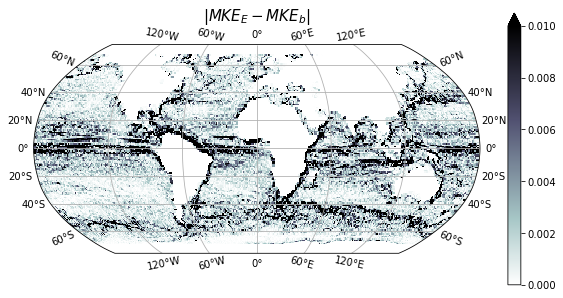

In [30]:
fig,ax = plot_maps(np.abs(ds_Estats['MKE']-ds_Lstats['MKE_i']),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert MKE_E-MKE_i\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['MKE']-ds_Lstats['MKE_b']),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert MKE_E-MKE_b\vert$',fontsize=15)
#ax.coastlines()

(-70.0, 70.0)

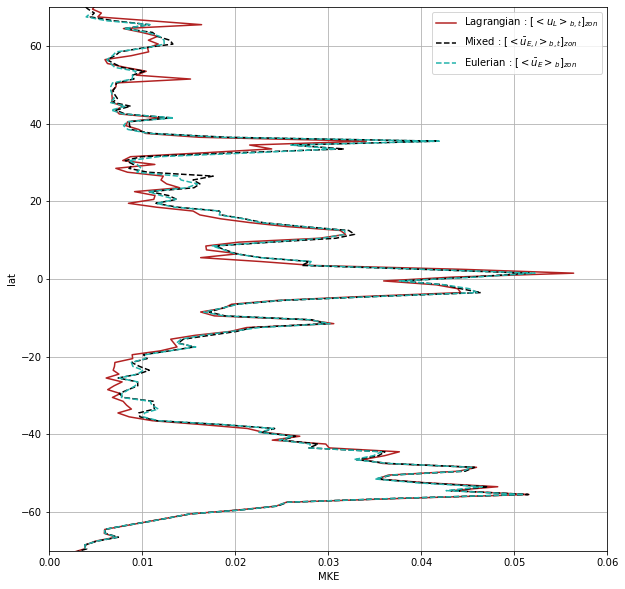

In [43]:
plt.figure(figsize=(10,10))
ds_Lstats['MKE_b'].mean('lon').plot(y='lat',c='firebrick',label=r'Lagrangian : $[<u_L>_{b,t}]_{zon}$')
ds_Lstats['MKE_i'].mean('lon').plot(y='lat',c='k',linestyle='--',label=r'Mixed : $[<\bar u_{E,i}>_{b,t}]_{zon}$')
ds_Estats['MKE'].mean('lon').plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian : $[<\bar u_E>_{b}]_{zon}$')
plt.grid()
plt.xlim(0,0.06);plt.legend()
plt.ylim(-70,70)

#### Variance : 
1) $<\overline{(u_E-\bar u_E)^2}>_b$ : variance of Eulerian velocity binned and average over space

2) $<(u_L-\bar u_{E,i})^2>_{b,t}$ : variance of Lagrangian velocity (using interpolated Eulerian mean), binned and averaged over time and space

3) $<(u_L-<u_L>_{b,t})^2>_{b,t}$ : variance of Lagrangian velocity (using binned Lagrangian velocity), binned and averaged over time and space

Here to compute the variance in the two first case, we remove a temporal mean to Eulerian velocity and a temporal mean interpolated over the drifters trajectory.

By nature it differs from the third case. In this last case, purely Lagrangian velocity are used meaning the average removed is already an average over time and space. 


Text(0.5, 1.0, 'Variance of Lagrangian zonal velocity : $<(u_L-<u_L>_{b,t})^2>_{b,t}$')

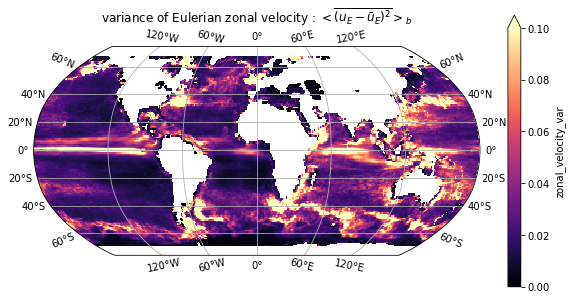

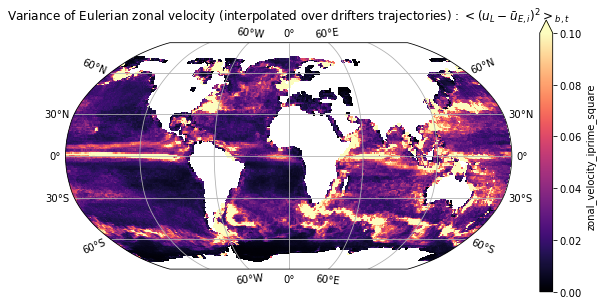

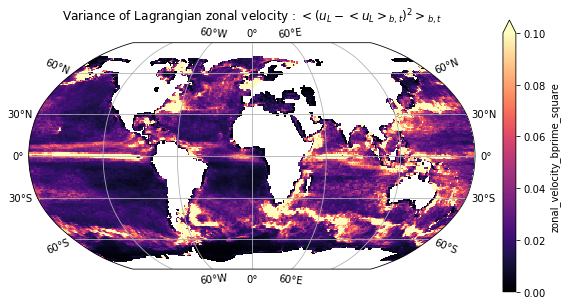

In [31]:
fig,ax = plot_maps(ds_Estats['zonal_velocity_var'],[0,0.1],colmap='magma')
ax.set_title(r'variance of Eulerian zonal velocity : $<\overline{(u_E-\bar u_E)^2}>_b$')
fig,ax = plot_maps(ds_Lstats['zonal_velocity_iprime_square'],[0,0.1],colmap='magma')
ax.set_title(r'Variance of Eulerian zonal velocity (interpolated over drifters trajectories) : $<(u_L-\bar u_{E,i})^2>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['zonal_velocity_bprime_square'],[0,0.1],colmap='magma')
ax.set_title(r'Variance of Lagrangian zonal velocity : $<(u_L-<u_L>_{b,t})^2>_{b,t}$')



Text(0.5, 1.0, '$\\vert <(u_L-\\bar u_{E,i})^2>_{b,t}- <(u_L-<u_{L}>_{b,t})^2>_{b,t}\\vert$')

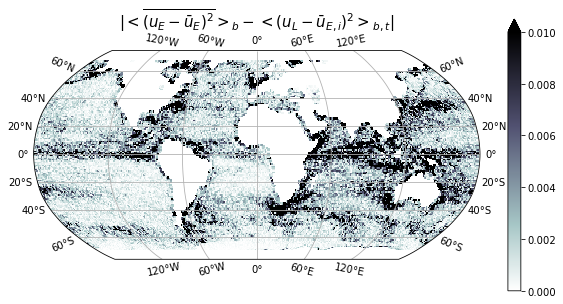

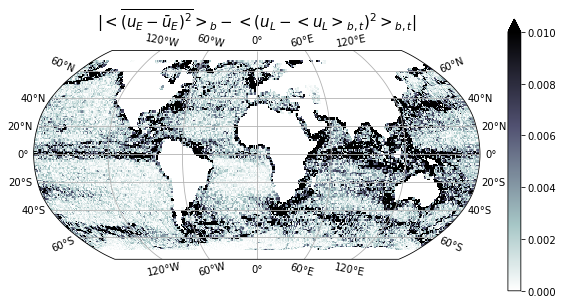

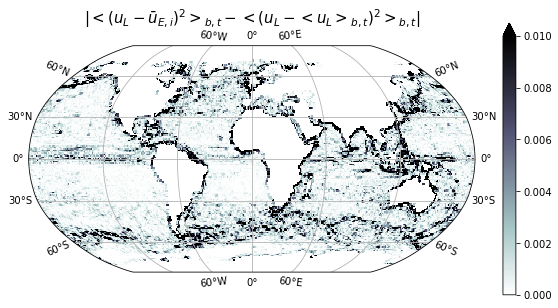

In [32]:
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_var']-ds_Lstats['zonal_velocity_iprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <\overline{(u_E-\bar u_{E})^2}>_{b}- <(u_L-\bar u_{E,i})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['zonal_velocity_var']-ds_Lstats['zonal_velocity_bprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <\overline{(u_E-\bar u_{E})^2}>_{b}- <(u_L-<u_{L}>_{b,t})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['zonal_velocity_iprime_square']-ds_Lstats['zonal_velocity_bprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <(u_L-\bar u_{E,i})^2>_{b,t}- <(u_L-<u_{L}>_{b,t})^2>_{b,t}\vert$',fontsize=15)

Text(0.5, 1.0, 'Variance of Lagrangian meridional velocity : $<(v_L-<v_L>_{b,t})^2>_{b,t}$')

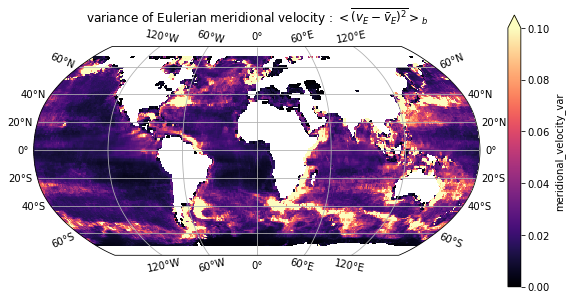

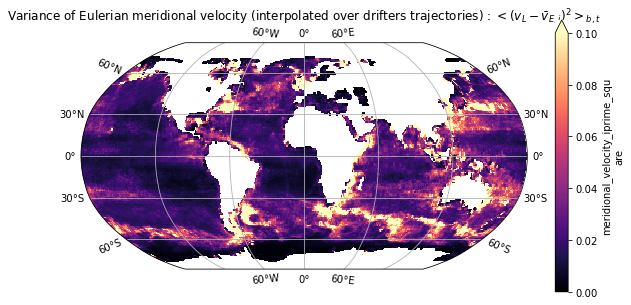

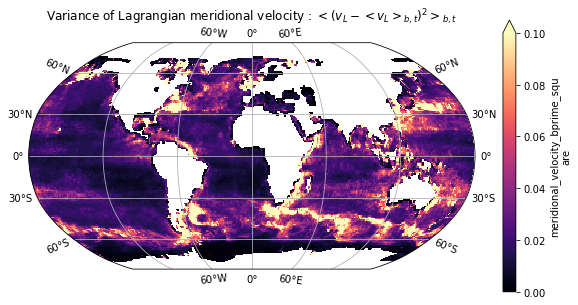

In [33]:
fig,ax = plot_maps(ds_Estats['meridional_velocity_var'],[0,0.1],colmap='magma')
ax.set_title(r'variance of Eulerian meridional velocity : $<\overline{(v_E-\bar v_E)^2}>_b$')
fig,ax = plot_maps(ds_Lstats['meridional_velocity_iprime_square'],[0,0.1],colmap='magma')
ax.set_title(r'Variance of Eulerian meridional velocity (interpolated over drifters trajectories) : $<(v_L-\bar v_{E,i})^2>_{b,t}$')
fig,ax = plot_maps(ds_Lstats['meridional_velocity_bprime_square'],[0,0.1],colmap='magma')
ax.set_title(r'Variance of Lagrangian meridional velocity : $<(v_L-<v_L>_{b,t})^2>_{b,t}$')




Text(0.5, 1.0, '$\\vert <(v_L-\\bar v_{E,i})^2>_{b,t}- <(v_L-<v_{L}>_{b,t})^2>_{b,t}\\vert$')

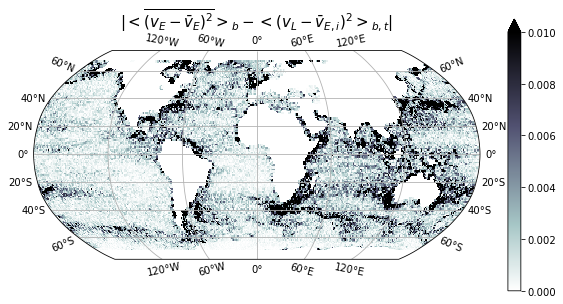

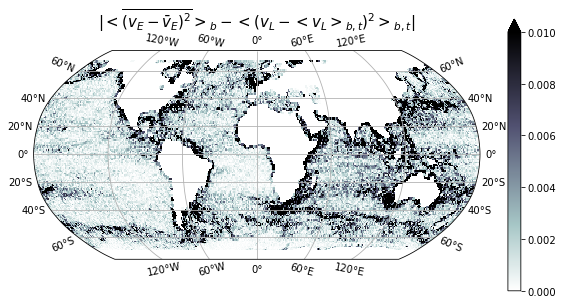

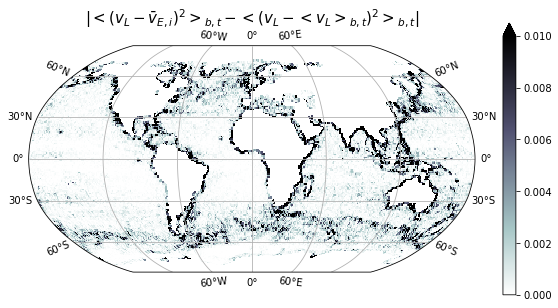

In [34]:
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_var']-ds_Lstats['meridional_velocity_iprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <\overline{(v_E-\bar v_{E})^2}>_{b}- <(v_L-\bar v_{E,i})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['meridional_velocity_var']-ds_Lstats['meridional_velocity_bprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <\overline{(v_E-\bar v_{E})^2}>_{b}- <(v_L-<v_{L}>_{b,t})^2>_{b,t}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['meridional_velocity_iprime_square']-ds_Lstats['meridional_velocity_bprime_square']
                         ),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert <(v_L-\bar v_{E,i})^2>_{b,t}- <(v_L-<v_{L}>_{b,t})^2>_{b,t}\vert$',fontsize=15)

In [40]:
ds_Estats['EKE'] = ds_Estats['zonal_velocity_var']+ds_Estats['meridional_velocity_var']
ds_Lstats['EKE_i'] = ds_Lstats['zonal_velocity_iprime_square']+ds_Lstats['meridional_velocity_iprime_square']
ds_Lstats['EKE_b'] = ds_Lstats['zonal_velocity_bprime_square']+ds_Lstats['meridional_velocity_bprime_square']

#### Notes : 
For simplification sake we will use the following notations :

1) EKE_E = $<\overline{(u_E-\bar u_E)^2}>_b+<\overline{(v_E-\bar v_E)^2}>_b$

2) EKE_i = $<(u_L-\bar u_{E,i})^2>_{b,t}+<(v_L-\bar v_{E,i})^2>_{b,t}$

3) EKE_b =  $<(u_L-<u_L>_{b,t})^2>_{b,t}+<(v_L-<v_L>_{b,t})^2>_{b,t}$

Text(0.5, 1.0, 'Lagrangian eddy kinetic energy : $EKE_b$')

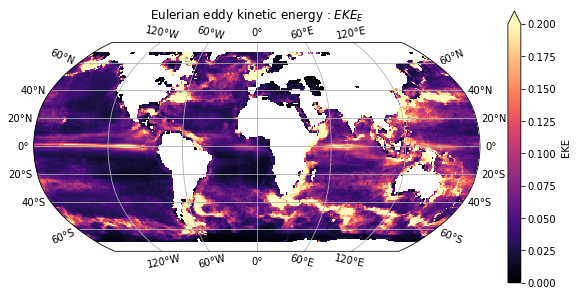

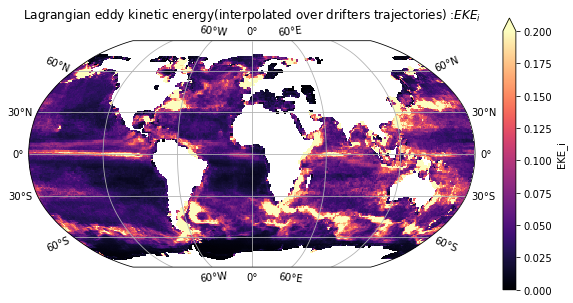

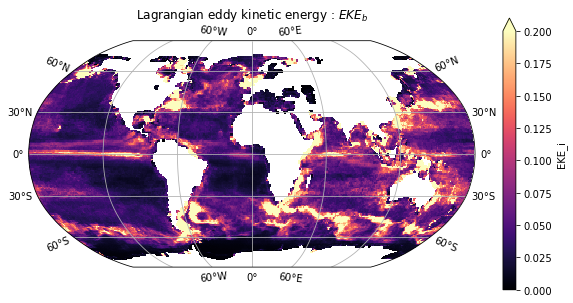

In [36]:
fig,ax = plot_maps(ds_Estats['EKE'],[0,0.2],colmap='magma')
ax.set_title(r'Eulerian eddy kinetic energy : $EKE_E$')
fig,ax = plot_maps(ds_Lstats['EKE_i'],[0,0.2],colmap='magma')
ax.set_title(r'Lagrangian eddy kinetic energy(interpolated over drifters trajectories) :$EKE_i$ ')
fig,ax = plot_maps(ds_Lstats['EKE_i'],[0,0.2],colmap='magma')
ax.set_title(r'Lagrangian eddy kinetic energy : $EKE_b$')

Text(0.5, 1.0, '$\\vert EKE_{i}-EKE_{b}\\vert$')

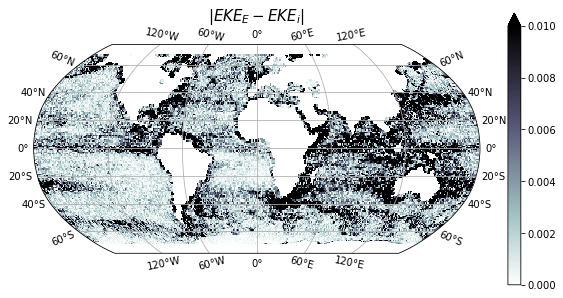

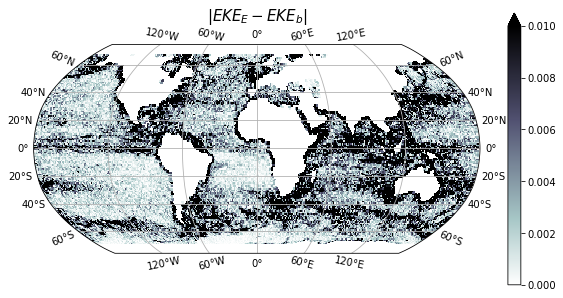

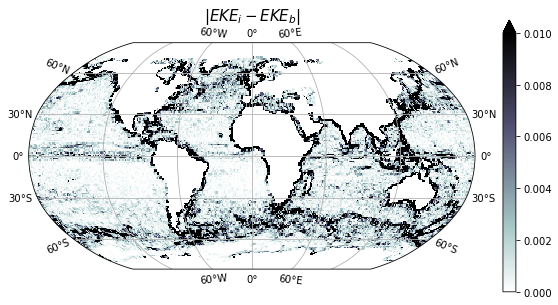

In [37]:
fig,ax = plot_maps(np.abs(ds_Estats['EKE']-ds_Lstats['EKE_i']),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert EKE_E-EKE_{i}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Estats['EKE']-ds_Lstats['EKE_b']),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert EKE_E-EKE_{b}\vert$',fontsize=15)
fig,ax = plot_maps(np.abs(ds_Lstats['EKE_i']-ds_Lstats['EKE_b']),[0,0.01],colmap='bone_r')
ax.set_title(r'$\vert EKE_{i}-EKE_{b}\vert$',fontsize=15)

(0.0, 0.5620253434106719)

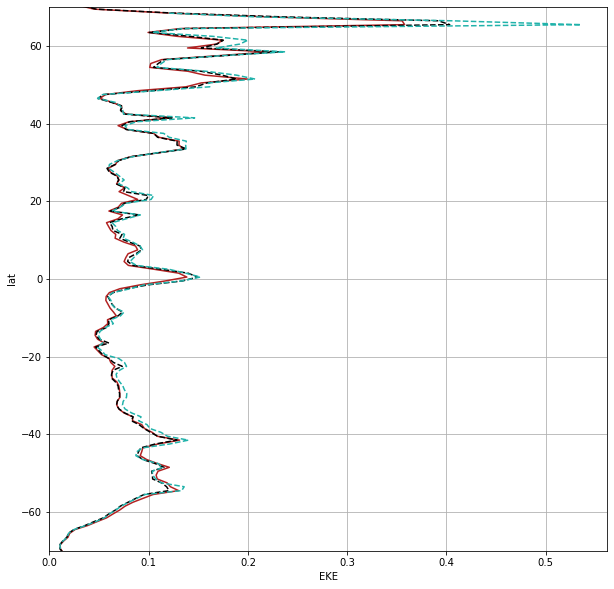

In [44]:
plt.figure(figsize=(10,10))
ds_Lstats['EKE_b'].mean('lon').plot(y='lat',c='firebrick',label=r'Lagrangian : $[<u_L>_{b,t}]_{zon}$')
ds_Lstats['EKE_i'].mean('lon').plot(y='lat',c='k',linestyle='--',label=r'Mixed : $[<\bar u_{E,i}>_{b,t}]_{zon}$')
ds_Estats['EKE'].mean('lon').plot(y='lat',c='lightseagreen',linestyle='--',label=r'Eulerian : $[<\bar u_E>_{b}]_{zon}$')
plt.grid()
plt.ylim(-70,70);plt.xlim(0,None)
#plt.xlim(0,0.06);plt.legend()

In [45]:
cluster.close()